### Build a image x label adjacency matrix

In [2]:
import os
import numpy as np
import re
import csv
import glob
from matplotlib import pyplot as plt
from PIL import Image
from scipy.misc import imresize
import matplotlib.patches as mpatches

In [3]:
DATA_DIRECTORY = "../../../project/rcc/deep_learning_hack/netdissect/broden1_224/"
OUTPUT_FOLDER = "../../../project2/bermanm/netdissect/"

FEATURE_NAMES = ['layer4']
categories_pixels = ['color', 'object', 'part', 'material']
categories_scalars = ['scene', 'texture']

In [4]:
def decode_index_dict(row):
    result = {}
    for key, val in row.items():
        if key in ['image', 'split']:
            result[key] = val
        elif key in ['sw', 'sh', 'iw', 'ih']:
            result[key] = int(val)
        else:
            item = [s for s in val.split(';') if s]
            for i, v in enumerate(item):
                if re.match('^\d+$', v):
                    item[i] = int(v)
            result[key] = item
    return result

In [5]:
def decode_label_dict(row):
    result = {}
    for key, val in row.items():
        if key == 'category':
            result[key] = dict((c, int(n))
                for c, n in [re.match('^([^(]*)\(([^)]*)\)$', f).groups()
                    for f in val.split(';')])
        elif key == 'name':
            result[key] = val
        elif key == 'syns':
            result[key] = val.split(';')
        elif re.match('^\d+$', val):
            result[key] = int(val)
        elif re.match('^\d+\.\d*$', val):
            result[key] = float(val)
        else:
            result[key] = val
    return result

In [6]:
# retrieve image and label informations
with open(os.path.join(DATA_DIRECTORY, "index.csv")) as f:
    images = [decode_index_dict(r) for r in csv.DictReader(f)]

with open(os.path.join(DATA_DIRECTORY, "label.csv")) as f:
    labels = [decode_label_dict(r) for r in csv.DictReader(f)]

In [7]:
# build an adjacency matrix for each image and each label
# the matrix is of dimension 63305 x 1198
def build_image_vs_label(images, labels, save_path="matrix.npy"):
    if not os.path.exists(os.path.join(OUTPUT_FOLDER, "visualization")):
        os.makedirs(os.path.join(OUTPUT_FOLDER, 'visualization'))
    save_path = os.path.join(OUTPUT_FOLDER, "visualization", save_path)
    if os.path.exists(save_path):
        print("loading")
        return np.load(save_path)
    
    image_vs_label = np.zeros((len(images), len(labels)+1))
    for i, image in enumerate(images):
        if (i % 100 == 0):
            print(i)
        lbs = np.array([])
        for cat in categories_pixels:
            for lb_img in image[cat]:
                lb_img = Image.open(os.path.join(DATA_DIRECTORY, "images", lb_img))
                cat_lbs = np.unique(np.array(list(lb_img.getdata())))[1:]
                lbs = np.concatenate((lbs, cat_lbs))
        for cat in categories_scalars:
            lbs = np.concatenate((lbs, np.array(image[cat])))
        lbs = np.unique(lbs.astype(int))
        image_vs_label[i].put(lbs, [1])
    np.save(save_path, image_vs_label)
    return image_vs_label

In [8]:
ivl = build_image_vs_label(images, labels)

loading


In [10]:
ivl[1, 21]

0.0

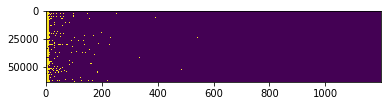

In [11]:
plt.imshow(ivl, aspect=0.004)

In [12]:
def load_feature_map():
    feature_path = os.path.join(OUTPUT_FOLDER, "dissection", "resnet18_places365")
    qtpath = os.path.join(OUTPUT_FOLDER, "dissection", "resnet18_places365", "quantile.npy")

    #qtpath = os.path.join(ALT_FOLDER, "quantile.npy")
    
    maxfeatures = [None] * len(FEATURE_NAMES)
    wholefeatures = [None] * len(FEATURE_NAMES)
    features_size = np.load(os.path.join(OUTPUT_FOLDER, "dissection", "resnet18_places365", "feature_size.npy"))
    mmap_files =  [os.path.join(OUTPUT_FOLDER, "dissection", "resnet18_places365", "%s.mmap" % feature_name)  for feature_name in FEATURE_NAMES]
    mmap_max_files = [os.path.join(OUTPUT_FOLDER, "dissection", "resnet18_places365", "%s_max.mmap" % feature_name) for feature_name in FEATURE_NAMES]
    for i, (mmap_file, mmap_max_file) in enumerate(zip(mmap_files,mmap_max_files)):
        wholefeatures[i] = np.memmap(mmap_file, dtype=float,mode='r', shape=tuple(features_size[i]))
        maxfeatures[i] = np.memmap(mmap_max_file, dtype=float, mode='r', shape=tuple(features_size[i][:2]))
        
    thresholds = np.load(qtpath)
    return wholefeatures[0], maxfeatures[0], thresholds

In [13]:
wholefeature, maxfeature, thresholds = load_feature_map()

### visualize all concepts associated to a single image

In [14]:
img = 25560
unit = None

In [15]:
cp = {0: (230, 255, 255),
        1: (0, 0, 0),
          2: (128, 128, 128),
          3: (255, 255, 255),
          4: (153, 102, 51),
          5: (0, 153, 51),
          6: (255, 153, 204),
          7: (153, 0, 255),
          8: (0, 0, 204),
          9: (255, 204, 0),
          10: (204, 0, 0),
          11: (255, 153, 0)}

In [16]:
size = 112
gap = 3
img_row = 432
img_col = 288

In [17]:
def pixel_concepts(image_id, img, concept, palette, labels=labels, dpi=1000):
    concept_labels = img[concept]
    for lbi, lb in enumerate(concept_labels):
        c_img = Image.open(os.path.join(DATA_DIRECTORY, "images", lb))
        unique_label = list(c_img.getdata())
        unique_label = np.unique(np.array([c[0] for c in unique_label]))
        unique_label = np.array([c for c in unique_label if c != 0])
        if list(unique_label) != []:
            label_map = {}
            label_map[0] = 0
            for i, label in enumerate(unique_label):
                label_map[label] = i+1

            c_pixel = c_img.load()
            gdheight = 1
            gdwidth = len(unique_label) + 1
            if concept == 'color':
                tiled = np.full(((size + gap) * gdheight - gap, (size + gap) * gdwidth - gap, 3), 255, dtype='uint8')
            else:
                tiled = np.full(((size + gap) * gdheight - gap, (size + gap) * gdwidth - gap, 4), 0, dtype='float')

            row = 0
            for col in range(len(unique_label) + 1):
                if col == len(unique_label):
                     c_img = np.array([[palette[label_map[c_pixel[i, j][0]]] for i in range(size)]
                         for j in range(size)])
                else:
                    c = unique_label[col]
                    c_img = np.array([[palette[label_map[c]] if c_pixel[i, j][0] == c else palette[0]
                               for i in range(size)] for j in range(size)])
                tiled[row * (size + gap) : row * (size + gap) + size, 
                        col * (size + gap) : col * (size + gap) + size,:] = c_img

            locs = np.arange(size // 2, gdwidth * size, size + gap)
            curr_labels = [labels[c-1]['name'] for c in unique_label] + ['combined']
            filename = str(image_id) + "_" + concept + "_" + str(lbi + 1) + ".png"
            plt.xticks(locs, curr_labels, rotation=90)
            plt.title(concept + " " + str(lbi + 1))
            plt.imshow(tiled)
            plt.savefig(os.path.join(OUTPUT_FOLDER, "visualization", "concepts", filename), dpi=dpi)
            plt.close()

In [18]:
def scalar_concepts(img, concept, labels=labels):
    res = ""
    if img[concept] != []:
        res = concept + ": "
        lbs = [labels[c-1]["name"] for c in img[concept]]
        res += ";".join(lbs)
    return res

In [19]:
def build_image(image_id, image_name, title, dpi=1000):
    image = Image.open(os.path.join(DATA_DIRECTORY, "images", image_name))
    plt.imshow(image)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(OUTPUT_FOLDER, "visualization", "concepts", str(image_id) + ".png"), dpi=dpi)

In [20]:
def probe(image_id, mode=None, images=images, labels=labels, color_palette=cp, max_labels=60, dpi=1000):
    hsv = plt.get_cmap('hsv')
    dp = hsv(np.linspace(0, 1.0, 60))
    dp = np.random.permutation(dp)
    dp_map = {}
    for i in range(max_labels):
        if i == 0:
            dp_map[i] = [0., 0.8, 1., 0.05]
        else:
            dp_map[i] = dp[i]

    img = images[image_id]
    img_name = img['image']
    dataset = img_name.split("/")[0]
    filename = img_name.split("/")[1]
    
    title = dataset + "_" + filename
    build_image(image_id, img_name, title)
    print("Dataset: {}".format(dataset))
    print("Image Name: {}".format(filename))

    pixel_concepts(image_id, img, "color", color_palette, dpi=dpi)
    pixel_concepts(image_id, img, "object", dp_map, dpi=dpi)
    pixel_concepts(image_id, img, "part", dp_map, dpi=dpi)
    pixel_concepts(image_id, img, "material", dp_map, dpi=dpi)
    
    if mode != None:
        file = os.path.join(OUTPUT_FOLDER, "visualization", "concepts", str(image_id) + "_" + mode[:-1] + "_" + mode[-1] + ".png")
        f_img = Image.open(file)
        plt.imshow(f_img)
        plt.xticks([])
        plt.yticks([])
    else:
        files = sorted(glob.glob(os.path.join(OUTPUT_FOLDER, "visualization", "concepts", str(image_id) + "*.png")))
        length = len(files)

        result = Image.new("RGB", (img_row, img_col * (length)))
        for i, file in enumerate(files):
            r_img = Image.open(file)
            r_img.thumbnail((img_row, img_col), Image.ANTIALIAS)
            x = i // (length) * img_row
            y = i % (length) * img_col
            w, h = r_img.size
            result.paste(r_img, (x, y, x + w, y + h))

        plt.imshow(result)
        plt.xticks([])
        plt.yticks([])
        scene = scalar_concepts(img, "scene")
        texture = scalar_concepts(img, "texture")
        subtitle = "[" + str(image_id) + "] " + scene + " " + texture
        plt.title(subtitle, size="large")
        filename = os.path.join(OUTPUT_FOLDER, "visualization", "concepts", str(image_id) + "_combined.jpg")
        plt.savefig(filename, dpi=dpi)

Dataset: ade20k
Image Name: ADE_train_00017896.jpg


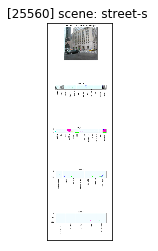

In [21]:
p = probe(img, dpi=800)

In [22]:
filename = os.path.join(OUTPUT_FOLDER, "visualization", "concepts", str(img) + "_combined.jpg")
view = Image.open(filename)

In [24]:
images[img]

{'image': 'ade20k/ADE_train_00017896.jpg',
 'split': 'train',
 'ih': 224,
 'iw': 224,
 'sh': 112,
 'sw': 112,
 'color': ['ade20k/ADE_train_00017896_color.png'],
 'object': ['ade20k/ADE_train_00017896_object.png'],
 'part': ['ade20k/ADE_train_00017896_part_1.png',
  'ade20k/ADE_train_00017896_part_2.png'],
 'material': [],
 'scene': [59],
 'texture': []}

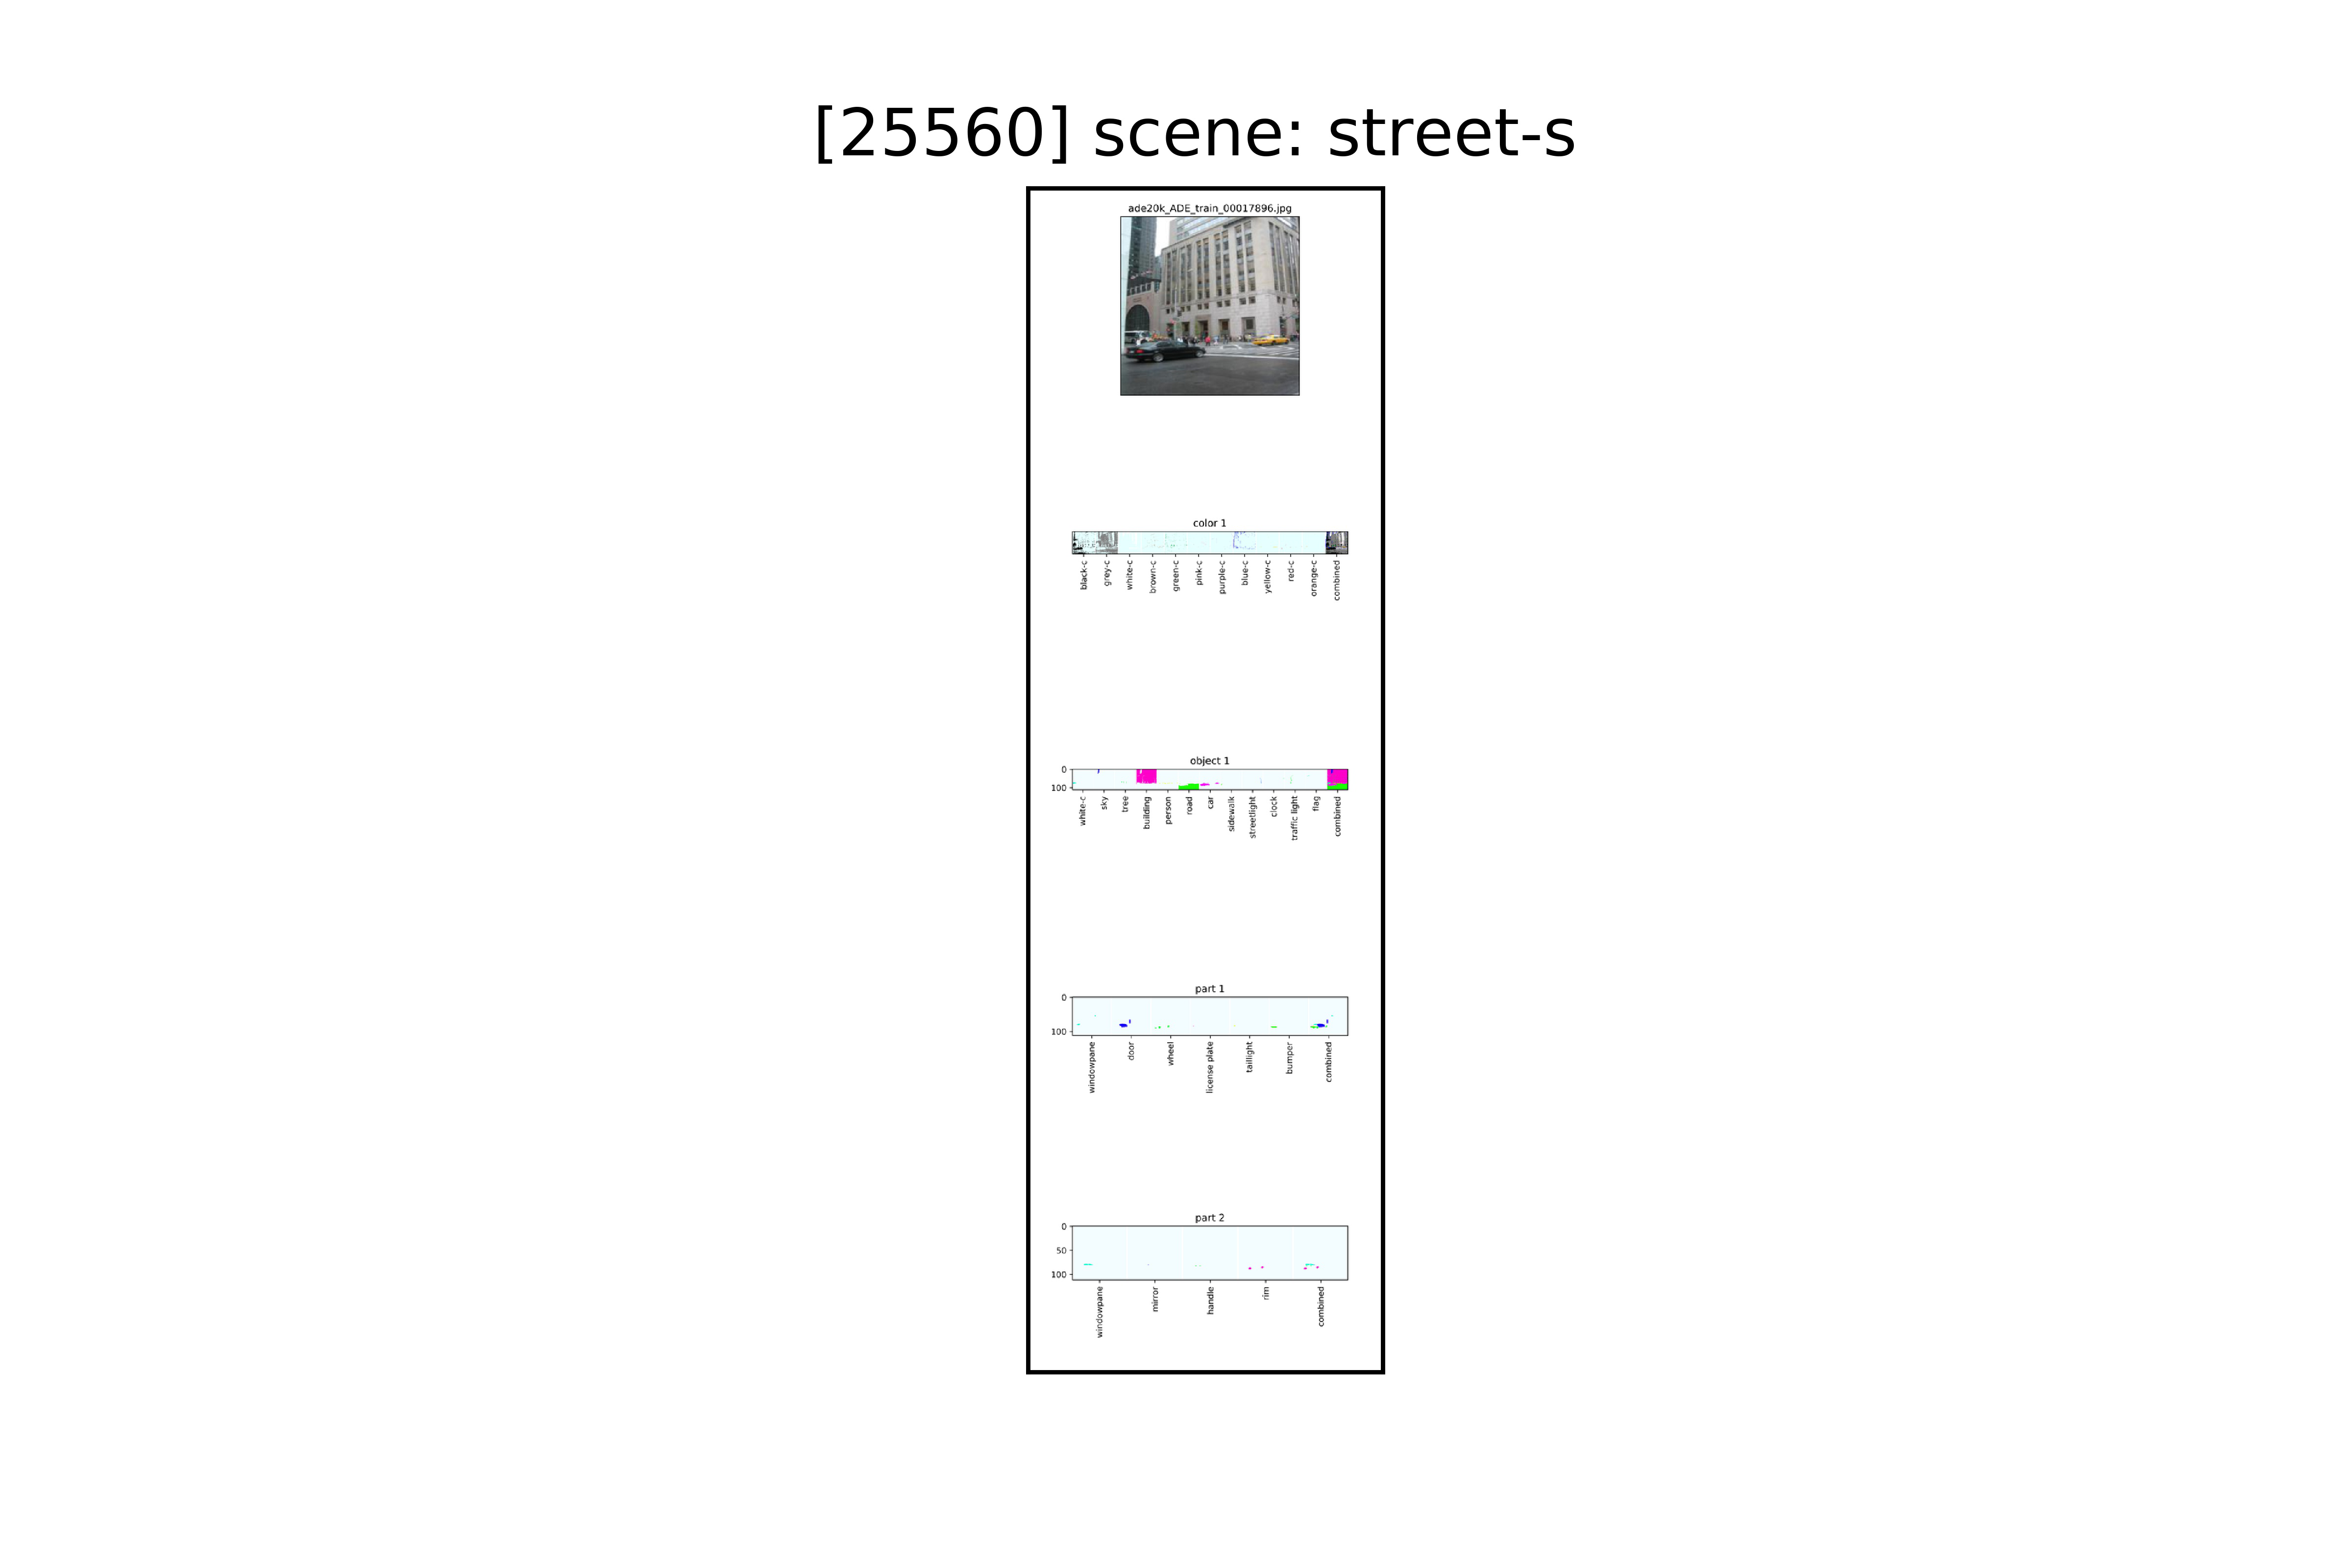

In [23]:
view

### visualize feature map

In [25]:
# visualize the dilated feature map of a single image and single unit
# if the unit id is given, probe this particular unit; othervise probe the unit with maximum activation
def probe_unit_fm(image_id, resize=112, images=images, wf=wholefeature, mf=maxfeature, unit_id=None): # data is not shuffled! hurray!!!
    wholef = wf[image_id]
    maxf = mf[image_id]
    if unit_id == None:
        print("No unit id provided, will probe the unit id with maximum activation")
        unit_id = np.argmax(maxf)
        print("Probe unit {}".format(unit_id))
    feature_map = wholef[unit_id]
    feature_map = imresize(feature_map, (resize, resize), mode='F')
    plt.imshow(feature_map, "hot")
    return unit_id, feature_map

In [26]:
# show only the activated part of the feature map
# if the unit id is given, probe this particular unit; otherwise probe the unit with maximum activation
def show_activated(image_id, images=images, th=thresholds, wf=wholefeature, mf=maxfeature, unit_id=None):
    unit_id, feature_map = probe_unit_fm(image_id, images=images, resize=224, wf=wf, mf=mf, unit_id=unit_id)
    
    print("Threshold for unit {}: {}".format(unit_id, th[unit_id]))
    print("Maximum activation for unit {}: {}".format(unit_id, np.max(wf[image_id][unit_id])))
    
    image = Image.open(os.path.join(DATA_DIRECTORY, "images", images[image_id]["image"])).convert("RGBA")
    feature_map[feature_map < th[unit_id]] = 0
    feature_map = feature_map / mf[image_id][unit_id]
    feature_map = Image.fromarray(np.uint8(plt.cm.hot(feature_map)*255)) # there might be some issues here
    combined = Image.blend(image, feature_map, 0.7)
    plt.imshow(combined)

In [27]:
img = 25560
unit = None

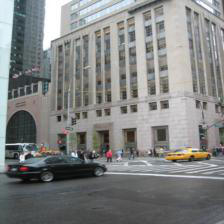

In [28]:
view = Image.open(os.path.join(DATA_DIRECTORY, "images", images[img]['image']))
view

No unit id provided, will probe the unit id with maximum activation
Probe unit 308


/home/canliu/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(308, array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

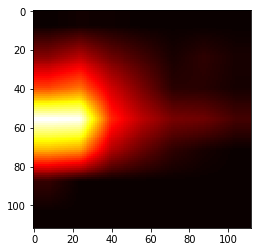

In [31]:
probe_unit_fm(img, unit_id=unit)

/home/canliu/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Threshold for unit 477: 5.7010640229096206
Maximum activation for unit 477: 8.411020278930664


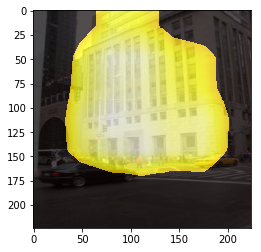

In [39]:
show_activated(img, unit_id=477)

### visualize IOU

In [34]:
# fetch all labels related to the image
def fetch_labels(image, labels=labels):
    label_ids = np.array([])
    for cat in categories_pixels:
        for cat_img in image[cat]:
            cat_lbs = np.unique(np.array(list((Image.open(os.path.join(DATA_DIRECTORY, "images", cat_img)).getdata()))))[1:]
            label_ids = np.concatenate((label_ids, cat_lbs))
    for cat in categories_scalars:
        label_ids = np.concatenate((label_ids, np.array(image[cat])))
    return np.uint16(np.unique(label_ids))

In [35]:
# calculate iou of a single image for each activated unit v.s. related label
def label_unit_IOU(image_id, th=thresholds, wf=wholefeature, mf=maxfeature, images=images, labels=labels):
    image_labels = fetch_labels(images[image_id], labels=labels)
    image_labels = [i for i in image_labels if i != 0]
    activated_units = np.argwhere(mf[image_id] > thresholds).flatten()
    
    num_units = len(activated_units)
    num_labels = len(image_labels)
    
    print("{} related labels, {} activated units".format(num_labels, num_units))
    tally_units = np.zeros(num_units,dtype=np.float64) # units
    tally_temp_labels = np.zeros(np.max(image_labels)+1, dtype=np.float64)
    tally_temp_both = np.zeros((np.max(image_labels)+1, num_units), dtype=np.float64)
    
    img = images[image_id]
    scalars, pixels = [], []
    for cat in categories_pixels:
        cat_pixels = np.empty((1, size, size))
        for cat_img in img[cat]:
            cat_img = Image.open(os.path.join(DATA_DIRECTORY, "images", cat_img))
            cat_lbs = list(cat_img.getdata())
            cat_lbs = np.array([t[0] for t in cat_lbs]).reshape(1, size, size)
            pixels.append(cat_lbs)
    pixels = np.concatenate(pixels)
    pixels_label = np.bincount(pixels.ravel())

    for cat in categories_scalars:
        scalars += img[cat]
        
    tally_temp_labels[:len(pixels_label)] += pixels_label
    tally_temp_labels[scalars] += size * size
    
    tally_labels = tally_temp_labels[tally_temp_labels != 0] # labels
    if len(tally_labels) > num_labels:
        tally_labels = tally_labels[1:] # exclude 0 
    
    for ind, unit_id in enumerate(activated_units):
        _, feature_map = probe_unit_fm(image_id, images=images, wf=wf, mf=mf, unit_id=unit_id)
        indexes = np.argwhere(feature_map > th[unit_id])
        tally_units[ind] += len(indexes)
        
        if len(pixels) > 0:
            tally_bt = np.bincount(pixels[:, indexes[:, 0], indexes[:, 1]].ravel())
            tally_temp_both[:len(tally_bt), ind] += tally_bt
        
        for scalar in scalars:
            tally_temp_both[scalar, ind] += len(indexes)
    
    tally_both = tally_temp_both[np.array([image_labels]), :][0] # intersection
    tally_units = np.tile(tally_units, (num_labels, 1))
    tally_labels = np.tile(tally_labels[:, np.newaxis], (1, num_units))

    iou_matrix = tally_both / (tally_units + tally_labels - tally_both + 1e-10)
    print("maximum iou: {}".format(np.max(iou_matrix)))
    label_names = [labels[i-1]['name'] for i in image_labels]
    ylocs = np.arange(num_labels)
    xlocs = np.arange(num_units)
    plt.yticks(ylocs, label_names, size=5)
    plt.xticks(xlocs, activated_units, rotation=90, size=4)
    plt.imshow(iou_matrix, "hot")
    plt.savefig(os.path.join(OUTPUT_FOLDER, "visualization", "iou", str(image_id)+".png"), dpi=500) 

32 related labels, 22 activated units
maximum iou: 0.5905096660808367


/home/canliu/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


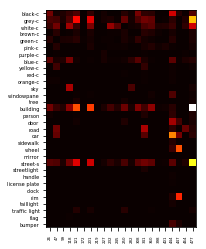

In [36]:
label_unit_IOU(img)

In [37]:
vis = Image.open(os.path.join(OUTPUT_FOLDER, "visualization", "iou", str(img)+".png"))

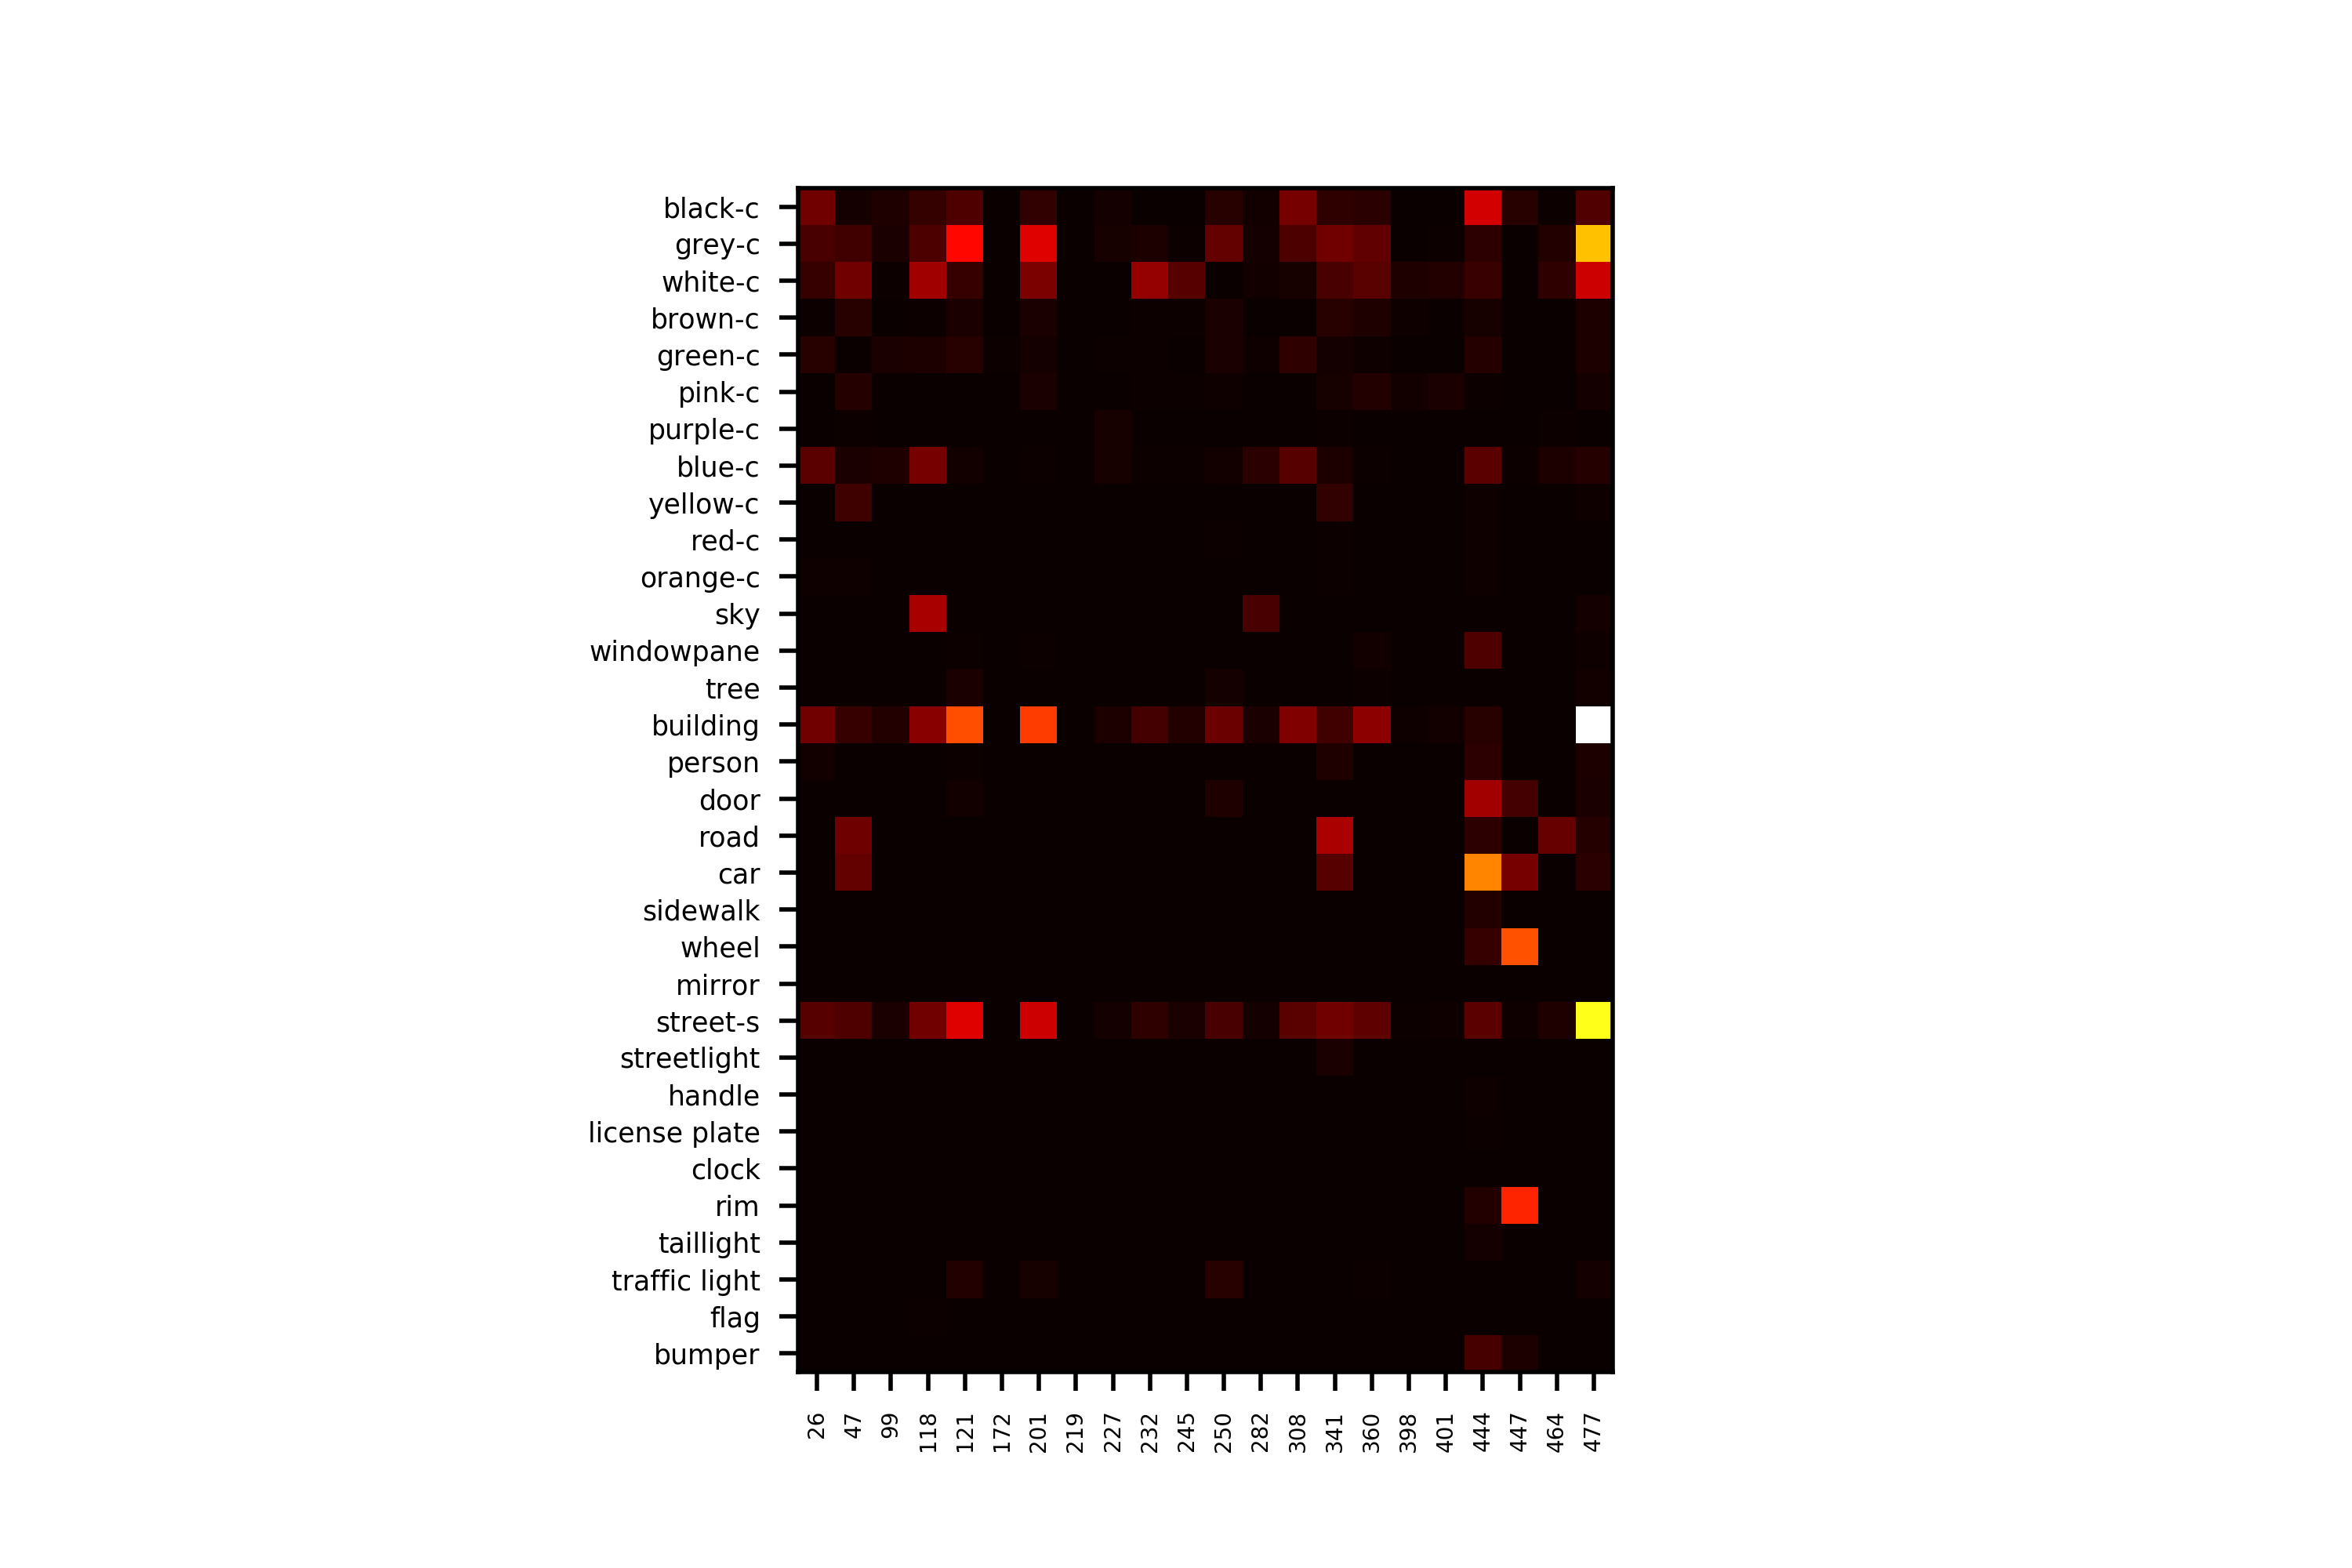

In [38]:
vis

### combined with class activation map

In [40]:
import pytorch_models
import torch
import scipy
from torch.autograd import Variable as V
from torchvision import transforms as trn
from torch.nn import functional as F

In [41]:
MODEL_DIRECTORY = "../../../project2/bermanm/netdissect/trained_cnns/resnet18_cam"
classes = ['indoor', 'nature', 'urban outdoor']
FEATURES_NAMES = ['layer4']
IMG_SIZE = 224

In [42]:
# hook features
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

In [43]:
# load the model trained by Kyoung previously
def load_model(features_names, model=21):
    arch = 'resnet18_cam'
    model = str(model).rjust(3, '0')
    model_file = os.path.join(MODEL_DIRECTORY, 'checkpoint_' + model + '_done.pth.tar')
    model = pytorch_models.__dict__[arch](num_classes=3)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {k[2:]: v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    model.eval()
    return model

In [44]:
# get softmax weight
def get_softmax_weight(model):
    params = list(model.parameters())
    weight_softmax = params[-2].data.numpy()
    weight_softmax[weight_softmax<0] = 0
    return weight_softmax

In [45]:
model = load_model(FEATURES_NAMES)

In [46]:
weight_softmax = get_softmax_weight(model)

In [47]:
# image transformer
def returnTF():
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # why normalize it this way? # need to calculate the mean again
    ])
    return tf

In [48]:
# feed image forward to attain feature map
def forward_image(images, ind, features_blobs, m, verbose=True):
    del features_blobs[:]
    tf = returnTF()    # image transformer
    img_path = os.path.join(DATA_DIRECTORY, "images", images[ind]["image"])
    img = Image.open(img_path)
    if verbose:
        plt.imshow(img)
    
    tf_img = tf(img)
    display_tf_img = np.rollaxis(tf_img.numpy(),0,3)
    
    input_img = V(tf_img.unsqueeze(0))
    logit = m.forward(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs, idx = probs.numpy(), idx.numpy()
    
    if verbose:
        print('--- SCENE CATEGORIES ---')
        for i in range(0, 3):
            print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    
    return features_blobs, idx, probs

In [49]:
# dot product the  
def dot(images, image_id, features_blobs, model, concept="", handles=None, epoch=21, verbose=True, save=True, dpi='figure'):
    image_data_path = os.path.join(OUTPUT_FOLDER, 'visualization', 'cam')
    img_path = os.path.join(DATA_DIRECTORY, "images", images[image_id]["image"])
    img = Image.open(img_path)
    features_blobs, idx, probs = forward_image(images, image_id, features_blobs, model, verbose=False)
    if concept != "":
        vis_img = Image.open(os.path.join(OUTPUT_FOLDER, "visualization", 
                                          "temp", str(image_id) + "_" + concept + ".jpg"))
        #plt.imshow(vis_img)
    else:
        vis_img = img
    if len(features_blobs) <= 2:
        feature_conv = features_blobs[0]
    else:
        print("features blobs is not emptied")
        return
    
    class_map = dict([(i, classes[i]) for i in range(len(classes))])
    if verbose:
        print(class_map)
    nc, h, w = feature_conv.shape # nc=512, h=14, w=14
    cams = []
    
    IMG_SIZE = vis_img.size[0]
    for i in range(3):
        class_idx = [idx[i]]
        cls = class_map[class_idx[0]]
        if verbose:
            print("class {}: {} {}".format(i+1, cls, probs[i]))
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cams.append(cam)
    
    norm = plt.Normalize(vmin=np.min(cams), vmax=np.max(cams))
    cams = np.concatenate([norm(cam).reshape(h, w) for cam in cams])
    resize_cams = scipy.misc.imresize(cams, (IMG_SIZE * 3, IMG_SIZE, 3))
    
    fig = plt.figure()
    for i in range(3):
        rc = resize_cams[i*IMG_SIZE:(i+1)*IMG_SIZE, :]
        class_idx = [idx[i]]
        cls = class_map[class_idx[0]]
        plt.imsave(os.path.join(image_data_path, cls + '.jpg'), rc, cmap="hot")
        rc = Image.open(os.path.join(image_data_path, cls + '.jpg'))
        combined_rc = Image.blend(vis_img, rc, 0.6)
        prob = probs[i]
        ax = fig.add_subplot(1, 3, i+1)
        ax.text(0, IMG_SIZE + IMG_SIZE / 10, cls + ": " + str(round(prob, 3)))
        ax.imshow(combined_rc)
        ax.set_xticks([])
        ax.set_yticks([])
        if save:
            plt.savefig(os.path.join(image_data_path, str(image_id) + "_" + str(epoch) + concept +'.jpg'), dpi=dpi)
        if i == 2 and handles != None:
            plt.legend(handles=patches, loc=7, borderaxespad=-10)

In [65]:
img = 2550
unit = None

In [66]:
images[img]

{'image': 'ade20k/ADE_train_00006722.jpg',
 'split': 'train',
 'ih': 224,
 'iw': 224,
 'sh': 112,
 'sw': 112,
 'color': ['ade20k/ADE_train_00006722_color.png'],
 'object': ['ade20k/ADE_train_00006722_object.png'],
 'part': [],
 'material': [],
 'scene': [0],
 'texture': []}

--- SCENE CATEGORIES ---
0.888 -> indoor
0.092 -> urban outdoor
0.021 -> nature


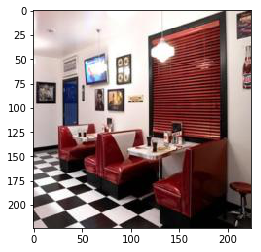

In [67]:
features_blobs, idx, probs = forward_image(images, img, features_blobs, model)

{0: 'indoor', 1: 'nature', 2: 'urban outdoor'}
class 1: indoor 0.8875199556350708
class 2: urban outdoor 0.09156478941440582
class 3: nature 0.020915288478136063


/home/canliu/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


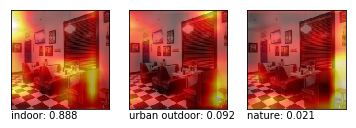

In [68]:
dot(images, img, features_blobs, model, dpi=800)

In [69]:
outpath = os.path.join(OUTPUT_FOLDER, "visualization", "cam", str(img) + "_" + str(21) + ".jpg")

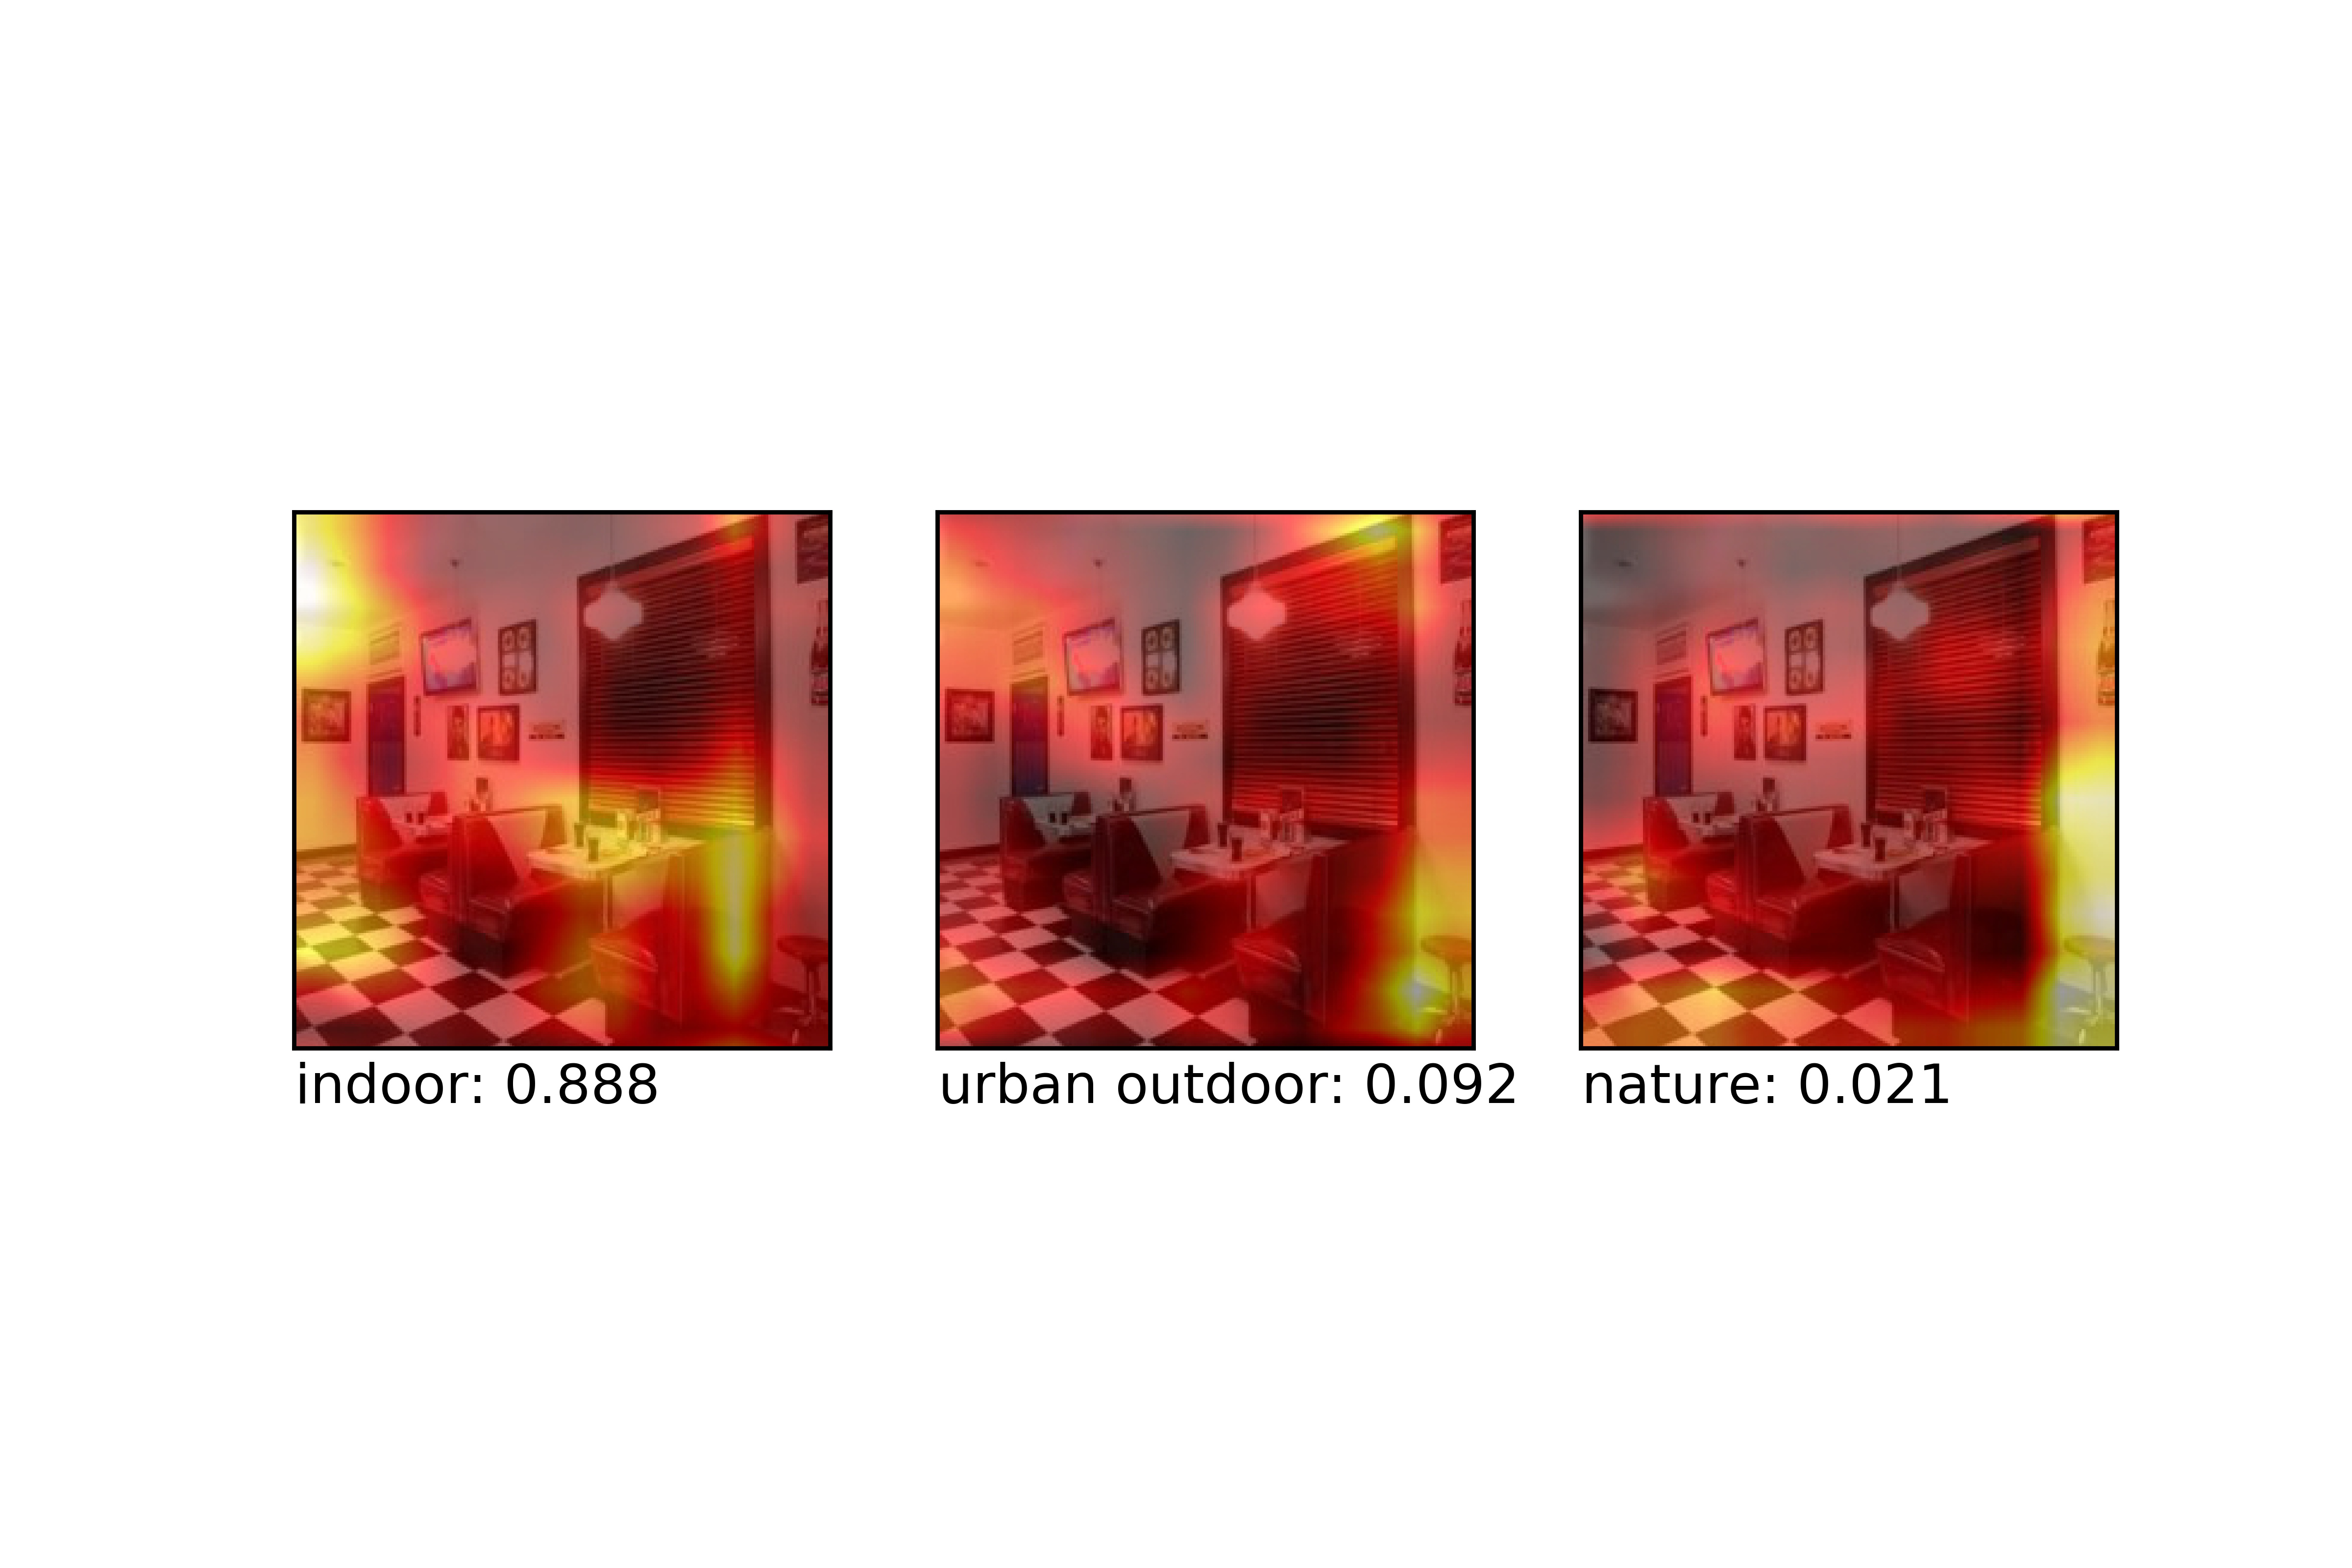

In [71]:
view = Image.open(outpath)
view

Objects: None; wall; floor; windowpane; door; ceiling; table; painting; light; lamp; seat; plate; drinking glass; stool


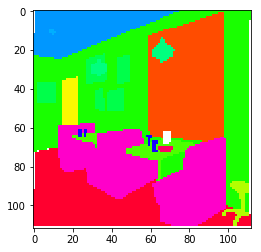

In [72]:
# combined with object annoation

# retrieve object annotation
image = images[img]
object_image = Image.open(os.path.join(DATA_DIRECTORY, 'images', image['object'][0]))
object_pixel = object_image.load()
objects = np.array([np.array([object_pixel[i, j][0] for i in range(object_image.size[0])]) 
                    for j in range(object_image.size[1])])
unique_objects = np.unique(objects)
object_names = ["None" if i == 0 else labels[i-1]['name'] for i in unique_objects]
print("Objects: {}".format("; ".join(object_names)))
num = len(unique_objects)


# build a random color map
hsv = plt.get_cmap('hsv')
dp = hsv(np.linspace(0, 1.0, 60))
dp = np.random.permutation(dp)
dp[0] = [0.0, 0, 0, 0]

object_map = {}
for i in range(num):
    object_map[unique_objects[i]] = i

# visualize 
object_vis = np.array([np.array([dp[object_map[objects[j, i]]] for i in range(object_image.size[0])])
                      for j in range(object_image.size[1])])
patches =[mpatches.Patch(color=dp[i],label=object_names[i]) for i in range(num)]
save_path = os.path.join(OUTPUT_FOLDER, "visualization", "temp", str(img) + "_" + "object.jpg")
plt.imshow(object_vis)
plt.imsave(save_path, object_vis)


{0: 'indoor', 1: 'nature', 2: 'urban outdoor'}
class 1: indoor 0.8875199556350708
class 2: urban outdoor 0.09156478941440582
class 3: nature 0.020915288478136063


/home/canliu/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


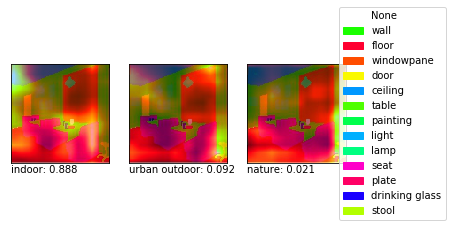

In [73]:
# combined with activation map
dot(images, img, features_blobs, model, concept="object", handles=patches, epoch=21, verbose=True, dpi=800)

In [74]:
datapath = os.path.join(OUTPUT_FOLDER, "visualization", "cam", str(img) + "_" + str(21) + "object.jpg")
view = Image.open(datapath)

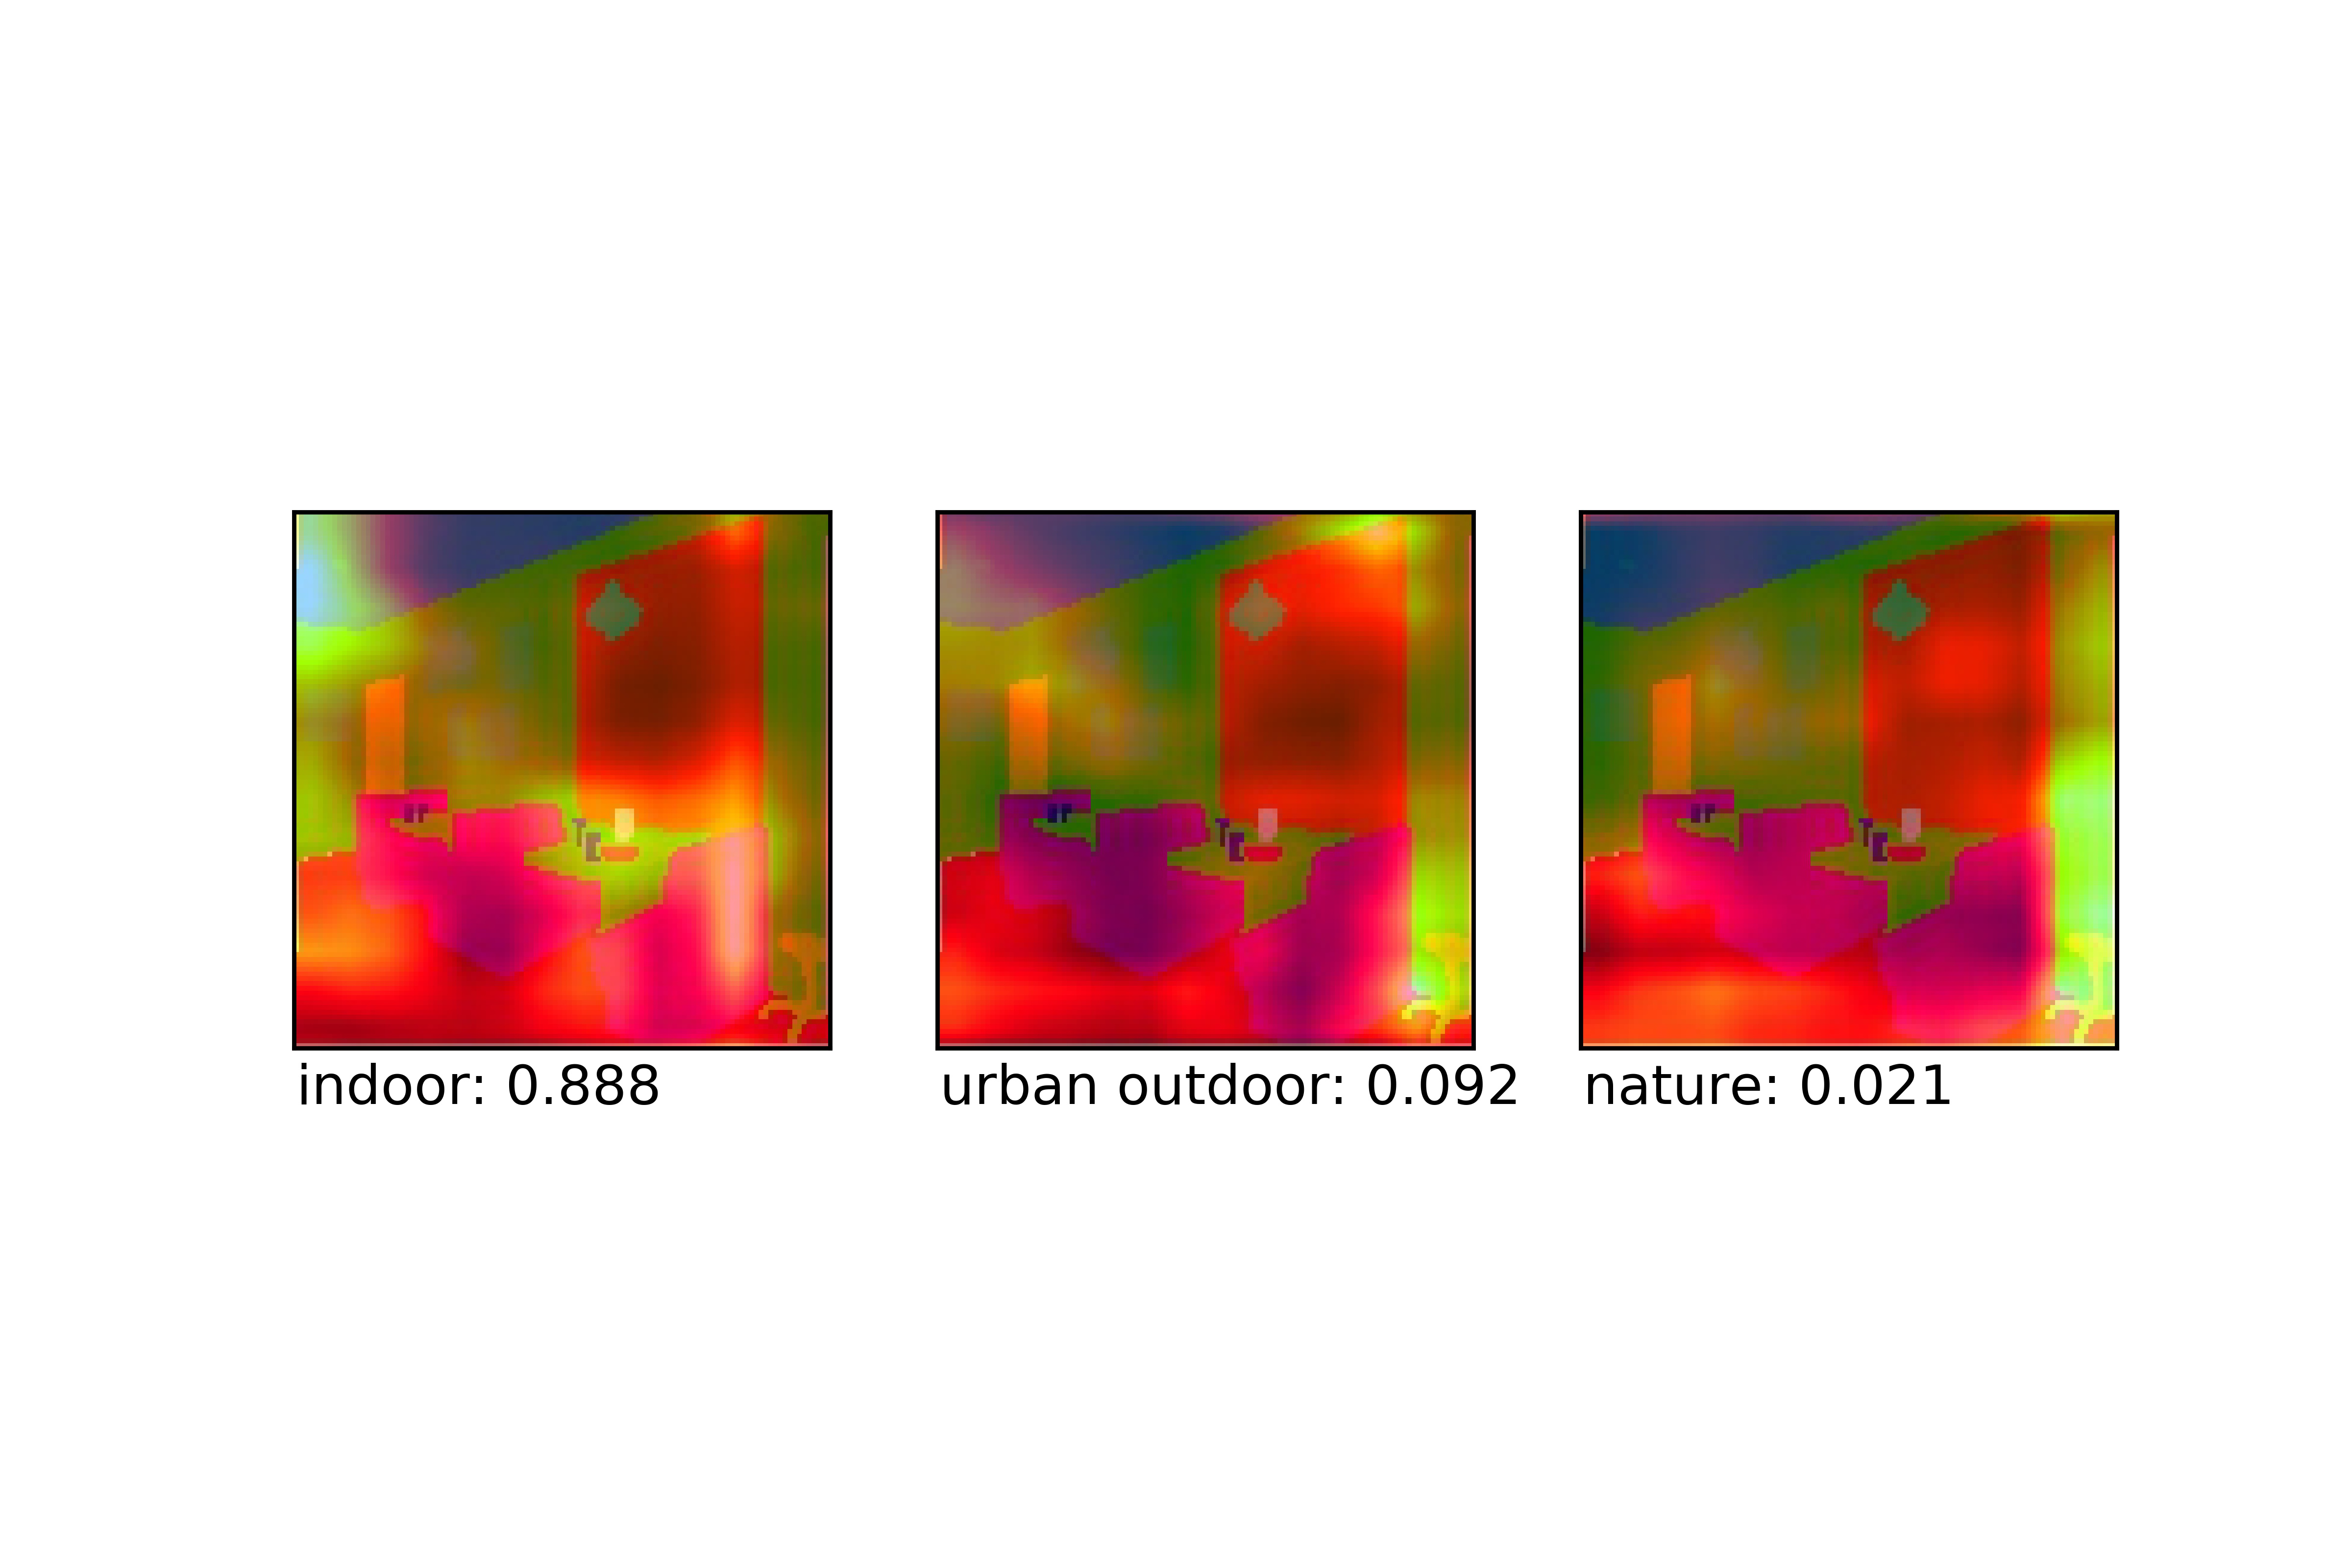

In [75]:
view